<a href="https://colab.research.google.com/github/ChrisDudu/Machine-Learning/blob/master/LSTM_on_SPY_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#current environment
import sys
print(sys.executable)

/usr/bin/python3


In [5]:
#!pip install tensorflow==2.0.0b1
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [6]:
#version of tensorflow
import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.1.0


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [7]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [8]:
#are we using the gpu ?
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [10]:
from google.colab import files
uploaded = files.upload()

Saving table_spy_short.csv to table_spy_short.csv


In [69]:
import io
df = pd.read_csv(io.BytesIO(uploaded['table_spy_short.csv']))
df.head()

,20030102,802,65.9268,65.9268.1,65.9268.2,65.9268.3,808.897,1,0,0.1
0,20030102,803,65.9268,65.9268,65.9268,65.9268,269.632,1,0,0
1,20030102,804,65.9268,65.9268,65.9268,65.9268,269.632,1,0,0
2,20030102,805,65.9491,65.9491,65.9416,65.9416,404.448,1,0,0
3,20030102,806,65.9045,65.9045,65.9045,65.9045,2831.140,1,0,0
4,20030102,808,65.9194,65.9194,65.9194,65.9194,1348.160,1,0,0


In [70]:
# import data
#df = pd.read_csv(r"C:\Users\User\OneDrive\CODE\DATA\table_spy.csv")
df.columns = ['date', 'time', 'open', 'high', 'low', 'close', 'volume', 'splits', 'earnings', 'dividends']

# FOR TESTING #
#start = int(2433094 / 100)
#df = df.iloc[-start:,:]
print(df.shape)
df.head()

(11742, 10)


,date,time,open,high,low,close,volume,splits,earnings,dividends
0,20030102,803,65.9268,65.9268,65.9268,65.9268,269.632,1,0,0
1,20030102,804,65.9268,65.9268,65.9268,65.9268,269.632,1,0,0
2,20030102,805,65.9491,65.9491,65.9416,65.9416,404.448,1,0,0
3,20030102,806,65.9045,65.9045,65.9045,65.9045,2831.140,1,0,0
4,20030102,808,65.9194,65.9194,65.9194,65.9194,1348.160,1,0,0


In [71]:
# transform date
df['datetime'] = df["date"].astype(str) + df["time"].astype(str)
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y%m%d%H%M")
df.set_index('datetime', inplace=True)
#df.set_index(['date', 'time'], inplace=True)
df.drop(labels=['date','time'], axis = 1, inplace=True)
df.drop(labels=['splits','earnings', 'dividends'], axis = 1, inplace=True)
print(df.shape)

(11742, 5)


In [72]:
df['target'] = np.where(df['close'] > df['open'], 1, 0)
df['target'] = df['target'].shift(-1)

df.drop(labels=['open','high', 'low', 'volume', 'target'], axis = 1, inplace=True)
df.head()

,close
datetime,
2003-01-02 08:03:00,65.9268
2003-01-02 08:04:00,65.9268
2003-01-02 08:05:00,65.9416
2003-01-02 08:06:00,65.9045
2003-01-02 08:08:00,65.9194


In [0]:
raw_seq = df['close']

In [0]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [75]:
n_steps = 3
n_features = 1
X, y = split_sequence(raw_seq, n_steps)
X[:5]

array([[65.9268, 65.9268, 65.9416],
       [65.9268, 65.9416, 65.9045],
       [65.9416, 65.9045, 65.9194],
       [65.9045, 65.9194, 65.9491],
       [65.9194, 65.9491, 66.0603]])

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [76]:
X.shape

(11739, 3)

In [77]:
y.shape

(11739,)

In [78]:
y[:5]

array([65.9045, 65.9194, 65.9491, 66.0603, 66.0158])

### Scale data

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)

print(X_scaled.mean(axis=0))
print(X_scaled.std(axis=0))

[3.09615184e-14 2.49564971e-14 3.93994593e-14]
[1. 1. 1.]


In [80]:
y = y.reshape(-1, 1)
y_scaled = scaler.fit_transform(y)

print(y_scaled.mean(axis=0))
print(y_scaled.std(axis=0))

[4.26119845e-15]
[1.]


In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.30, random_state=42)

print(f'Size of training: {len(X_train)}')
print(f'Size of testing: {len(X_test)}')

Size of training: 8217
Size of testing: 3522


In [82]:
X_train.shape

(8217, 3)

In [0]:
#X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [85]:
print(n_steps)
print(n_features)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

3
1
(8217, 3, 1)
(8217, 1)
(3522, 3, 1)
(3522, 1)


In [86]:
#tf.keras.backend.clear_session()
#tf.random.set_seed(51)
#np.random.seed(51)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True, input_shape=(n_steps, n_features)),
  tf.keras.layers.LSTM(60, return_sequences=False),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1, activation='relu')])

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 60)             14880     
_________________________________________________________________
lstm_5 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 46,071
Trainable params: 46,071
Non-trainable params: 0
_________________________________________________________________


In [87]:
# fit network
history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

# list all data in history
print(history.history.keys())

Train on 8217 samples, validate on 3522 samples
8217/8217 [==============================] - 5s 645us/sample - loss: 0.9928 - val_loss: 1.0168
dict_keys(['loss', 'val_loss'])


In [88]:
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=1)
print('test loss, test acc:', results)


# Evaluate on test data
3522/3522 [==============================] - 13s 4ms/sample - loss: 1.0168
test loss, test acc: 1.0167976583349303


In [0]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [90]:
rmse = np.sqrt(np.mean(predictions - y_test) **2)
rmse

66.38017440132964

### Plot the data

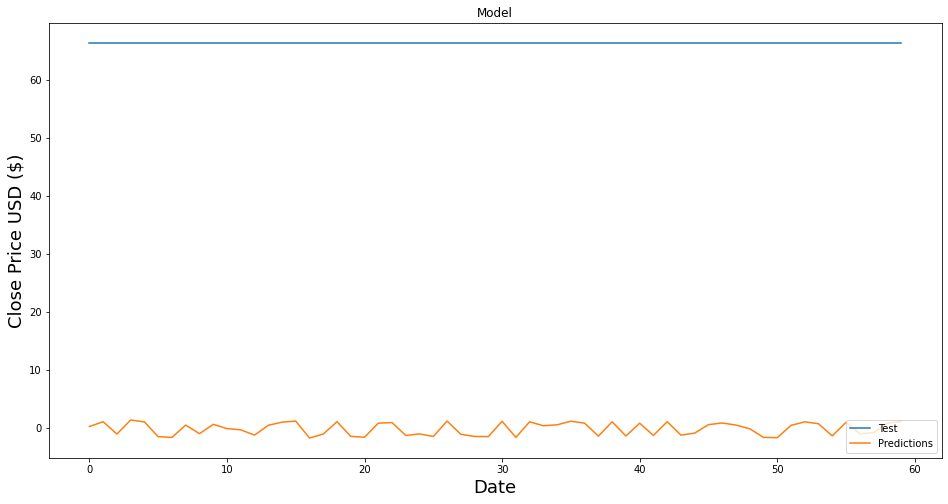

In [91]:
#Plot the data
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(predictions[-60:])
plt.plot(y_test[-60:])
plt.legend(['Test', 'Predictions'], loc='lower right')
plt.show()